# **Modelling and Evaluation Notebook**

## Objectives

* Answer business requirement 2:
    - The client is interested to predict whether a cherry leaf is healthy or contains powdery mildew. 
    - The agreed criteria for the model performance is 97% accuracy.

## Inputs

* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/test
* inputs/mildew_dataset/cherry-leaves/validation
* image shape embeddings

## Outputs

* Cherry Leave Images distribution plot in train, validation, and test dataset.
* Data augmentation.
* Class indices to change prediction inference in labels.
* ML model creation and training.
* Save trained model.
* Plot model earning curve for performance.
* Model evaluation on pickle file.
* Tuning model hyperparameters for achieving agreed accuracy. 
* Saved improved model and training metrics
* Validation model on the random image file prediction.

## Additional Comments

---

## Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\zoe\\development\\ML-Mildew-Detector-II\\jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\zoe\\development\\ML-Mildew-Detector-II'

### Import libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread

### Set input directories for train, validation and test paths

In [5]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [7]:
version = 'v1-mildew'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [8]:
# Set the labels
labels = os.listdir(train_path)
print('Class Labels are', labels)

Class Labels are ['healthy', 'powdery_mildew']


### Set image shape

In [9]:
## Import image shape embedding saved at repo
version = 'v1-mildew'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Plot number of images in train, test and validation dataset

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




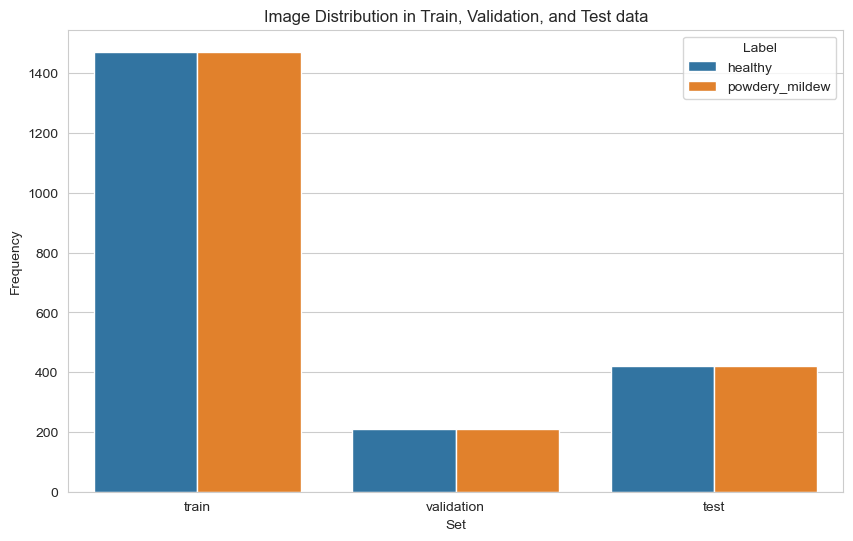

In [10]:
import glob

data_dirs = ['train', 'validation', 'test']

df_freq = pd.DataFrame([])

for folder in data_dirs:
    for label in os.listdir(os.path.join(my_data_dir, folder)):
        image_count = len(os.listdir(os.path.join(my_data_dir, folder, label)))
        df_freq = df_freq.append(pd.Series(data={'Set': folder, 'Label': label, 'Frequency': image_count}), ignore_index=True)
        print(f"* {folder} - {label}: {image_count} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))  
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Image Distribution in Train, Validation, and Test data")
plt.xlabel("Set")
plt.ylabel("Frequency")
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

----

## Image data augmentation

### Import and Initialize ImageDataGenerator

Generate augmented images to produce variations of the original images for training the deep learning model, thereby enhancing its ability to handle a wider range of real-world scenarios.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment training image dataset

In [12]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment validation image dataset

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Save class_indices

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1-mildew/class_indices.pkl']

---

## Model Creation

### Set up ML Model layout

* Import model package and create model

In [53]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

def create_mildew_tf_model():
    model = Sequential()

    # Add Convolutional and Pooling Layers
    model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
    model.add(Dropout(0.2))  # Add dropout after the first convolutional layer
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(Dropout(0.3))  # Add dropout after the second convolutional layer
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(Dropout(0.3))  # Add dropout after the third convolutional layer
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Add Fully Connected Layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with adjusted learning rate and metrics
    optimizer = Adam(learning_rate=0.001) #change optimizer
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Define callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Fit the model with modified batch size and epochs
model = create_mildew_tf_model()
history = model.fit(
    train_set,
    validation_data=validation_set,
    epochs=50,  
    batch_size=25,  
    callbacks=[early_stopping, reduce_lr]  # Apply early stopping and learning rate reduction
)

Epoch 1/50
148/148 [==============================] - 96s 647ms/step - loss: 0.3076 - accuracy: 0.8509 - val_loss: 0.1622 - val_accuracy: 0.9714
Epoch 2/50
148/148 [==============================] - 97s 651ms/step - loss: 0.0609 - accuracy: 0.9803 - val_loss: 0.0894 - val_accuracy: 0.9762
Epoch 3/50
148/148 [==============================] - 103s 695ms/step - loss: 0.0619 - accuracy: 0.9803 - val_loss: 0.0402 - val_accuracy: 0.9929
Epoch 4/50
148/148 [==============================] - 104s 703ms/step - loss: 0.0362 - accuracy: 0.9885 - val_loss: 0.0506 - val_accuracy: 0.9905
Epoch 5/50
148/148 [==============================] - 117s 790ms/step - loss: 0.0885 - accuracy: 0.9701 - val_loss: 0.0589 - val_accuracy: 0.9810
Epoch 6/50
148/148 [==============================] - 105s 706ms/step - loss: 0.0487 - accuracy: 0.9830 - val_loss: 0.0174 - val_accuracy: 0.9976
Epoch 7/50
148/148 [==============================] - 103s 693ms/step - loss: 0.0264 - accuracy: 0.9905 - val_loss: 0.0125 - v

In [70]:
create_mildew_tf_model().summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
dropout_18 (Dropout)         (None, 254, 254, 16)      0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
dropout_19 (Dropout)         (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 60, 60, 32)       

### Save the best tuned model and training history

In [54]:
# Save the model and training history for future reference
model.save('outputs/v1-mildew/mildew_detecting_model.h5')

## Model Evaluation

### Plot model learning curve for its fitting status

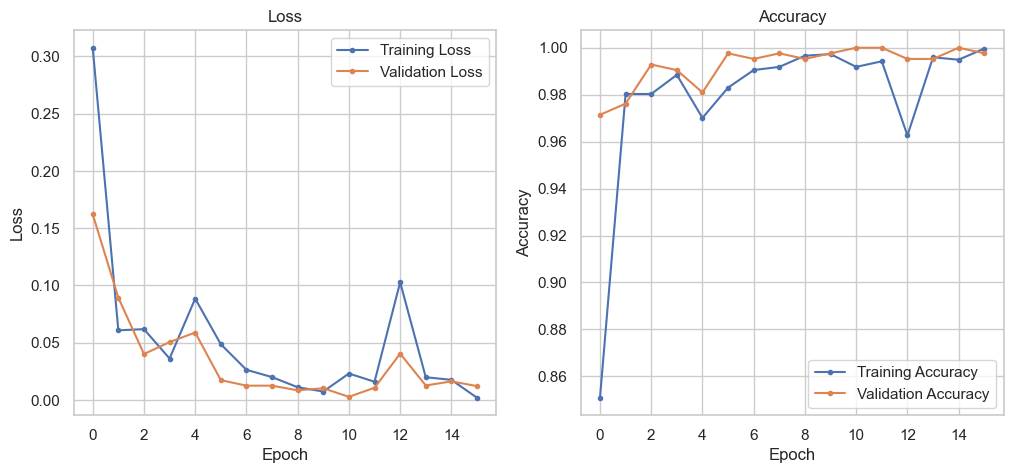

In [55]:
#plot model learning curve
losses = pd.DataFrame(model.history.history)

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Set the style
sns.set(style="whitegrid")

# Loss plot
losses[['loss', 'val_loss']].plot(style='.-', ax=ax1)
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(["Training Loss", "Validation Loss"])
ax1.grid(True)

# Accuracy plot
losses[['accuracy', 'val_accuracy']].plot(style='.-', ax=ax2)
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(["Training Accuracy", "Validation Accuracy"])
ax2.grid(True)

# Save the plots
plt.savefig(f'{file_path}/model_training_metrics3.png', bbox_inches='tight', dpi=150)

# Show the combined plot
plt.show()

### Fit the model with test dataset for loss and accuracy evaluation 

In [22]:
#Evaluation on test data

#Load saved model
from keras.models import load_model
model = load_model('outputs/v1-mildew/mildew_detecting_model.h5')

#Fit the model to test set
mildew_eva = model.evaluate(test_set)

joblib.dump(value=mildew_eva,
            filename=f"outputs/v1-mildew/mildew_model_evaluation3.pkl")

43/43 [==============================] - 4s 87ms/step - loss: 0.0049 - accuracy: 0.9988


['outputs/v1-mildew/mildew_model_evaluation3.pkl']

Plot the test set evaluation metrics bart chart

43/43 [==============================] - 3s 75ms/step - loss: 0.0049 - accuracy: 0.9988


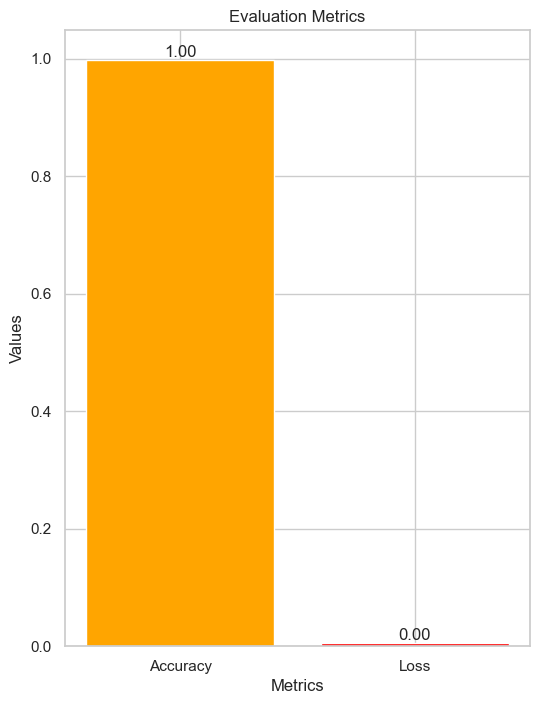

In [19]:
loss, accuracy = model.evaluate(test_set)
sns.set(style='whitegrid')

# Plot the evaluation metrics
plt.figure(figsize=(6, 8))

# Bar plot for accuracy and loss
metrics = ['Accuracy', 'Loss']
values = [accuracy, loss]

plt.bar(metrics, values, color=['orange', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Values')

# Display the values on the bars
for i in range(len(metrics)):
    plt.text(i, values[i], f'{values[i]:.2f}', ha='center', va='bottom', fontsize=12)

plt.title('Evaluation Metrics')
plt.savefig(f'{file_path}/model_evaluation_metrics.png', dpi=150)  # Save figure
plt.show()

### Model confusion matrix and classification analysis with test_set

#### Prepare the dataset

In [23]:
X_test = []  # Initialize an empty list to store images
Y_test = []  # Initialize an empty list to store labels

for _ in range(844):  # Loop through the test_set
    img_batch, label_batch = test_set.next()
    for img, label in zip(img_batch, label_batch):
        X_test.append(img)
        Y_test.append(label)

# Convert the lists to NumPy arrays
X_test = np.array(X_test)
Y_test = np.array(Y_test).flatten()  # Flatten Y_test to make it one-dimensional

In [25]:
print(X_test.shape)
print(Y_test.shape)

(16576, 256, 256, 3)
(16576,)


#### Compute Confusion Matrix and plot the matrix for test set

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
def generate_confusion_matrix(X, y, model, save_name=None):
    """
    Generate and plot a confusion matrix.

    Args:
    X: Input data.
    y: True labels.
    model: The trained model.
    class_labels (list): List of class labels.
    save_name (str, optional): File path to save the figure. Default is None (not saved).

    Returns:
    None
    """  
    
    
    y_pred = model.predict(X).reshape(-1)
    y_pred = np.where(y_pred<0.97,0,1) 

    cm = confusion_matrix(y, y_pred)
    print("---  Confusion Matrix  ---")
    print(cm)
    
    class_labels = {'healthy', 'powdery_mildew'}

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)

    sns.heatmap(cm, annot=True, fmt="d", cmap="cool",
                xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    if save_name:
        plt.savefig(f'{file_path}/{save_name}', dpi=150)  # Save the figure

    plt.show()


---  Confusion Matrix  ---
[[8380    0]
 [ 136 8060]]


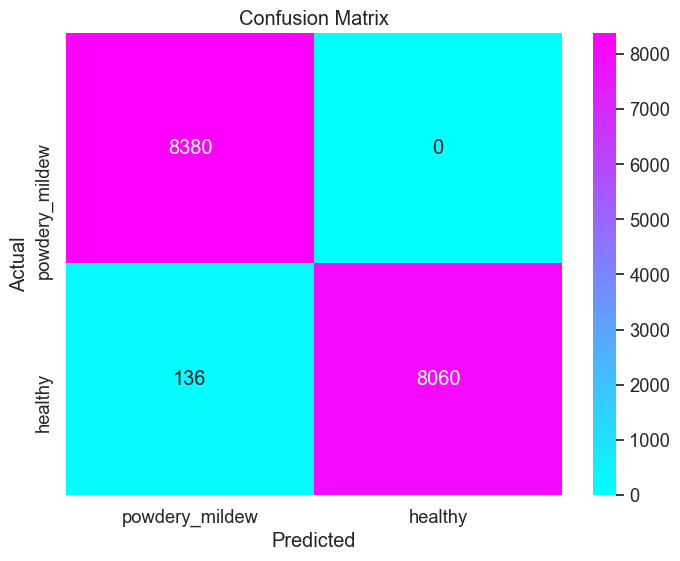

In [29]:
generate_confusion_matrix(X_test, Y_test, model, save_name="confusion_matrix_test.png")

#### Generate Classification Report for test set

In [30]:
from sklearn.metrics import classification_report
import os

In [31]:
def generate_classification_report(X, y, model, save_name):
    """
    Generate a classification report and save it to a CSV file.

    Args:
    X: Input data.
    y: True labels.
    model: The trained model.
    target_names (list): List of class labels.
    save_name (str): File name for saving the report as a CSV file.

    Returns:
    None
    """
    
    # Generate predictions
    y_pred = model.predict(X).reshape(-1)
    y_pred = np.where(y_pred<0.97,0,1) 
    
    class_names = ['healthy', 'powdery_mildew']

    # Generate the classification report as a dictionary
    report = classification_report(y, y_pred, target_names=class_names, output_dict=True)

    # Create a DataFrame from the report and transpose it for better readability
    df_report = pd.DataFrame(report).transpose()

    # Save the report to a CSV file
    csv_file_path = os.path.join(file_path, save_name)
    df_report.to_csv(csv_file_path, index=True)


In [32]:
generate_classification_report(X_test, Y_test, model, save_name="classification_report_test.csv")

### New/Live life data prediction

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


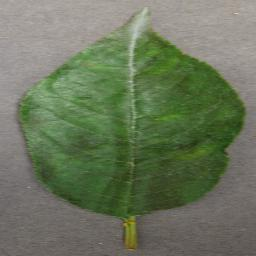

In [60]:
from tensorflow.keras.preprocessing import image

pointer = 20
label = labels[1]  # select healthy [0] or powdery_mildew contained [1]

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Predict the new/live data to its class with a probability

In [61]:
#convert image to array

test_image = image.img_to_array(pil_image)
test_image = np.expand_dims(test_image, axis=0)/255
print(test_image.shape)

#fit the trained model for class probabilities
pred_prob = model.predict(test_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_prob > 0.97]

if pred_class == target_map[0]:
    pred_prob = 1 - pred_prob

print(pred_prob)
print(pred_class)

(1, 256, 256, 3)
0.9999858
powdery_mildew


## Push files to Repo

In [ ]:
with open('.gitignore', 'r') as file:
    contents = file.read()
    print(contents)

Install Git LFS for large file storage

In [43]:
!git lfs install

Updated Git hooks.
Git LFS initialized.


Track files with the .h5 extension

In [44]:
!git lfs track "outputs/v1-mildew/*.h5"

Tracking "outputs/v1-mildew/*.h5"


In [46]:
!git lfs push --all origin main

In [ ]:
!git add .
!git commit -m"Add large file and new plots to github"
!git push

Push the reduced sized new model and it's metrics to repo

In [71]:
!git add .
!git commit -m"add new slots"
!git push

[main 5587849] add new slots
 2 files changed, 110 insertions(+), 6 deletions(-)
 create mode 100644 outputs/v1-mildew/model_evaluation_metrics.png


To https://github.com/yuyizhong/ML-Mildew-Detector-.git
   0c72935..5587849  main -> main
